In [34]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer

In [2]:
!pip install opencv-python

In [35]:
from tensorflow.keras.models import Sequential

In [5]:
!pip install tensorflow

In [36]:
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0

In [49]:
directory_root = 'E:/NU courses/ML 475/Project/PlantVillage'

In [50]:
width=256
height=256
depth=3

In [51]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [52]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [53]:
image_size = len(image_list)

In [54]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [55]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [56]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [57]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 


[INFO] Spliting data to train, test


In [58]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [61]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))


In [60]:
from tensorflow.keras.layers import Conv2D

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)       

In [70]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")


ValueError: decay is deprecated in the new Keras optimizer, pleasecheck the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [64]:
from tensorflow.keras.optimizers import Adam

In [75]:
opt=Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam')

In [77]:
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


In [78]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

C:\Users\shami\AppData\Local\Temp\ipykernel_17528\1273247788.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
73/73 [==============================] - 304s 4s/step - loss: 0.6528 - accuracy: 0.2362 - val_loss: 1.4887 - val_accuracy: 0.0795
Epoch 2/25
73/73 [==============================] - 290s 4s/step - loss: 0.2572 - accuracy: 0.3517 - val_loss: 0.5348 - val_accuracy: 0.0694
Epoch 3/25
73/73 [==============================] - 306s 4s/step - loss: 0.1585 - accuracy: 0.5668 - val_loss: 0.5839 - val_accuracy: 0.0626
Epoch 4/25
73/73 [==============================] - 344s 5s/step - loss: 0.1272 - accuracy: 0.6668 - val_loss: 0.9323 - val_accuracy: 0.0660
Epoch 5/25
73/73 [==============================] - 307s 4s/step - loss: 0.1175 - accuracy: 0.6874 - val_loss: 0.5416 - val_accuracy: 0.1387
Epoch 6/25
73/73 [==============================] - 297s 4s/step - loss: 0.1059 - accuracy: 0.7269 - val_loss: 1.2766 - val_accuracy: 0.1218
Epoch 7/25
73/73 [==============================] - 293s 4s/step - loss: 0.1087 - accuracy: 0.7145 - val_loss: 0.8198 - val_accuracy: 0.3621
Epoch 8/25
73

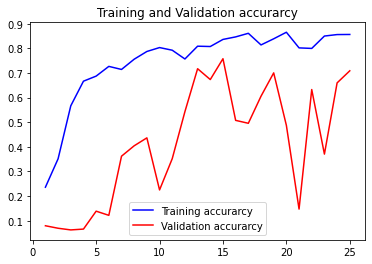

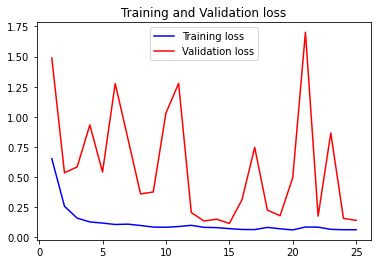

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [81]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 15s 796ms/step - loss: 0.1399 - accuracy: 0.7090
Test Accuracy: 70.89678645133972


In [82]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))


[INFO] Saving model...
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_2
......vars
...layers\activation_3
......vars
...layers\activation_4
......vars
...layers\activation_5
......vars
...layers\activation_6
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_5
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
.

In [83]:
loaded_model = pickle.load(open('cnn_model.pkl', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-04 22:40:24        10219
metadata.json                                  2022-12-04 22:40:24           64
variables.h5                                   2022-12-04 22:40:28    697305440
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_2
......vars
...layers\activation_3
......vars
...layers\activation_4
......vars
...layers\activation_5
......vars
...layers\activation_6
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...

In [92]:
loaded_model = pickle.load(open('C:\\Users\\shami\\Downloads\\cnn_model.pkl', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-04 22:40:24        10219
metadata.json                                  2022-12-04 22:40:24           64
variables.h5                                   2022-12-04 22:40:28    697305440
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_2
......vars
...layers\activation_3
......vars
...layers\activation_4
......vars
...layers\activation_5
......vars
...layers\activation_6
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...

In [ ]:
E:\NU courses\ML 475\Project

In [ ]:
E:\NU courses\ML 475\Project\PlantVillage\New Folder\Potato___Early_blight

In [99]:
image_dir="E:\\NU courses\\ML 475\\Project\\PlantVillage\\New Folder\\Potato___Early_blight\\0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG"

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [100]:
image_dir

'E:\\NU courses\\ML 475\\Project\\PlantVillage\\New Folder\\Potato___Early_blight\\0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG'

In [101]:
result=model.predict(npp_image)

print(result)

1/1 [==============================] - 1s 830ms/step
[[3.7724465e-05 4.7144269e-08 9.9993026e-01 2.7877924e-08 5.1289608e-09
  5.0747250e-11 5.0653601e-09 2.9689261e-06 4.8002257e-16 2.2545995e-05
  5.6841036e-06 6.8538104e-09 5.9873338e-07 1.7540558e-11 5.5868931e-08]]


In [102]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.99993026
Potato___Early_blight
